In [91]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import initializers
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import ModelCheckpoint
import os
from tensorflow.python import keras
import tempfile
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import seaborn as sns
import sys
import math
import random as rd
from sklearn.model_selection import KFold
import statistics
from math import sqrt
import binning
import loaddata


In [2]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
massskim=True

In [3]:
bkg=loaddata.loadbkg()
sig=loaddata.loadsig(massskim=massskim)
llepMC=loaddata.loadcontrol_MC(controltype="llep")
zllMC=loaddata.loadcontrol_MC(controltype="zll")
llepdata=loaddata.loadcontrol_data(controltype="llep")
zlldata=loaddata.loadcontrol_data(controltype="zll")
print("dataset prepared")

Background set prepared
Now binning
signal set prepared
Now binning
control set MC prepared
Now binning
control set MC prepared
Now binning
control set data prepared
Now binning
control set data prepared
Now binning
dataset prepared


In [57]:
import methods
import initialize

In [6]:
models_forbin=initialize.models_debug2

In [7]:
(databkg_ML_bin,databkg_test_bin,MLuse_bkg,MLusetag_bkg)=initialize.spliting(bkg)
del bkg
(datasig_ML_bin,datasig_test_bin,MLuse_sig,MLusetag_sig)=initialize.spliting(sig)
del sig

In [18]:
binsused=[]
j=0
i=models_forbin['binindex'][j][0]
m1=models_forbin['mass'][j][0]
m2=models_forbin['mass'][j][1]
print("for mass1= ",m1,", mass2= ",m2)
models_forbin['significance'].append([])
models_forbin['traintag'].append([])
models_forbin['trainfraction'].append([])

for mass1=  1400 , mass2=  1350


In [67]:
features_train=methods.feature_choice(min(bins.selections[i][1][1],16)-1)
X0=databkg_ML_bin[i][(features_train+[b'evt_scale1fb',b'GenSusyMScan1',b'GenSusyMScan2',b'absweight',b'bkgtype',b'w2'])[:]]
y0=databkg_ML_bin[i][b'sigtag']
X1=datasig_ML_bin[i][(features_train+[b'evt_scale1fb',b'GenSusyMScan1',b'GenSusyMScan2',b'absweight',b'bkgtype',b'w2'])[:]]
y1=datasig_ML_bin[i][b'sigtag']
models_forbin['traintag'][j].append([MLusetag_bkg[i],MLusetag_sig[i]])
models_forbin['trainfraction'][j].append([MLuse_bkg[i],MLuse_sig[i]])

In [68]:
X0_train, X0_val, y0_train, y0_val = train_test_split(X0, y0, test_size=0.1, random_state=42)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.1, random_state=90)
binsused.append(i)
X0_train=X0_train.reset_index(drop=True)
y0_train=y0_train.reset_index(drop=True)
X0_val=X0_val.reset_index(drop=True)
y0_val=y0_val.reset_index(drop=True)
X1_train=X1_train.reset_index(drop=True)
y1_train=y1_train.reset_index(drop=True)
X1_val=X1_val.reset_index(drop=True)
y1_val=y1_val.reset_index(drop=True)
val0=pd.concat([X0_val,y0_val],axis=1)
val1=pd.concat([X1_val,y1_val],axis=1)
train0=pd.concat([X0_train,y0_train],axis=1)
train1=pd.concat([X1_train,y1_train],axis=1)

In [69]:
print("train on ",X0_train.shape[0]," background", X1_train.shape[0]," signals, validate on ",X0_val.shape[0],"background",X1_val.shape[0],"signals")

train on  7447  background 162265  signals, validate on  828 background 18030 signals


In [70]:
nsample=3*np.max([X0_train.shape[0],X1_train.shape[0]])
ids0=np.arange(X0_train.shape[0])
ids1=np.arange(X1_train.shape[0])
choices0 = np.random.choice(ids0, nsample)
choices1 = np.random.choice(ids1, nsample)
res_X_train=pd.concat([X0_train.iloc[choices0,:],X1_train.iloc[choices1,:]])
res_y_train=pd.concat([y0_train.iloc[choices0],y1_train.iloc[choices1]])
res_X_train=res_X_train.reset_index(drop=True)
res_y_train=res_y_train.reset_index(drop=True)
nsample=3*np.max([X0_val.shape[0],X1_val.shape[0]])
ids0=np.arange(X0_val.shape[0])
ids1=np.arange(X1_val.shape[0])
choices0 = np.random.choice(ids0, nsample)
choices1 = np.random.choice(ids1, nsample)

In [71]:
res_X_val=pd.concat([X0_val.iloc[choices0,:],X1_val.iloc[choices1,:]])
res_y_val=pd.concat([y0_val.iloc[choices0],y1_val.iloc[choices1]])
res_X_val=res_X_val.reset_index(drop=True)
res_y_val=res_y_val.reset_index(drop=True)
print (res_y_train[res_y_train==0].shape[0], res_y_train[res_y_train==1].shape[0], res_y_val[res_y_val==0].shape[0], res_y_val[res_y_val==1].shape[0])

486795 486795 54090 54090


In [72]:
def make_model(metrics = METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
                    keras.layers.Dense(
                    30, kernel_initializer='normal', activation='sigmoid',
                     input_shape=(len(features_train),)),
                     keras.layers.Dropout(0.5),
                     keras.layers.Dense(
                     10, kernel_initializer='normal', activation='sigmoid'),
                     keras.layers.Dense(
                     10, kernel_initializer='normal', activation='sigmoid'),
                      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
                ])
        adam=optimizers.Adam(lr=0.001)
        model.compile(
                     optimizer='Adam',
                    loss='binary_crossentropy',
                     metrics=metrics)
        return model

In [73]:
filepath="weights_T1bbbb_bin_"+str(i)+".best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [74]:
model = make_model()
print("start training on bin ",i)
model_history=model.fit(x=res_X_train[features_train[:]],
y=res_y_train,
batch_size=20000,
epochs=200,
verbose=0,
callbacks = callbacks_list,
validation_data=(res_X_val[features_train[:]], res_y_val))

start training on bin  33

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to weights_T1bbbb_bin_33.best.hdf5

Epoch 00002: val_accuracy did not improve from 0.50000

Epoch 00003: val_accuracy improved from 0.50000 to 0.85686, saving model to weights_T1bbbb_bin_33.best.hdf5

Epoch 00004: val_accuracy did not improve from 0.85686

Epoch 00005: val_accuracy did not improve from 0.85686

Epoch 00006: val_accuracy did not improve from 0.85686

Epoch 00007: val_accuracy did not improve from 0.85686

Epoch 00008: val_accuracy did not improve from 0.85686

Epoch 00009: val_accuracy did not improve from 0.85686

Epoch 00010: val_accuracy did not improve from 0.85686

Epoch 00011: val_accuracy did not improve from 0.85686

Epoch 00012: val_accuracy improved from 0.85686 to 0.85922, saving model to weights_T1bbbb_bin_33.best.hdf5

Epoch 00013: val_accuracy did not improve from 0.85922

Epoch 00014: val_accuracy did not improve from 0.85922

Epoch 00015: val_accuracy did not


Epoch 00117: val_accuracy did not improve from 0.88086

Epoch 00118: val_accuracy improved from 0.88086 to 0.88183, saving model to weights_T1bbbb_bin_33.best.hdf5

Epoch 00119: val_accuracy did not improve from 0.88183

Epoch 00120: val_accuracy did not improve from 0.88183

Epoch 00121: val_accuracy improved from 0.88183 to 0.88214, saving model to weights_T1bbbb_bin_33.best.hdf5

Epoch 00122: val_accuracy did not improve from 0.88214

Epoch 00123: val_accuracy did not improve from 0.88214

Epoch 00124: val_accuracy did not improve from 0.88214

Epoch 00125: val_accuracy did not improve from 0.88214

Epoch 00126: val_accuracy did not improve from 0.88214

Epoch 00127: val_accuracy did not improve from 0.88214

Epoch 00128: val_accuracy did not improve from 0.88214

Epoch 00129: val_accuracy did not improve from 0.88214

Epoch 00130: val_accuracy did not improve from 0.88214

Epoch 00131: val_accuracy improved from 0.88214 to 0.88215, saving model to weights_T1bbbb_bin_33.best.hdf5



plotting history


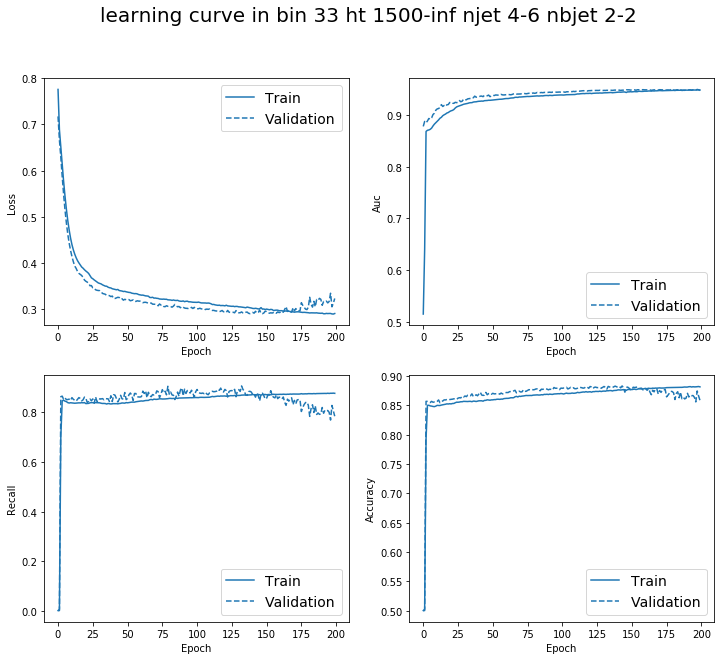

In [75]:
def plot_metrics_1(history,title):
    metrics =  ['loss','auc','recall','accuracy']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig=plt.figure(figsize=(12,10))
    fig.suptitle(title, fontsize=20)
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        ax=fig.add_subplot(2,2,n+1)
        ax.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        ax.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Validation')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(name)
        ax.legend(loc='best',prop={'size': 14})
    return fig
print("plotting history")
histroyplot=plot_metrics_1(model_history,'learning curve in bin '+str(i)+' ht '+str(bins.selections[i][0][0])
                       +"-"+str(bins.selections[i][0][1])+" njet "+str(bins.selections[i][1][0])+"-"+str(bins.selections[i][1][1]-1)
                       +" nbjet "+str(bins.selections[i][2][0])+"-"+str(bins.selections[i][2][1]-1))

In [76]:
histroyplot.savefig("learning_curve_bin"+str(i)+".png")
histroyplot.savefig("learning_curve_bin"+str(i)+".pdf")
#histroyplot.savefig("learning_curve_bin"+str(i)+".eps")

In [77]:
print("plotting score distribution")
model.load_weights(filepath)
val0[b'MLscore']=model.predict(val0[features_train[:]], batch_size=20000)
val1[b'MLscore']=model.predict(val1[features_train[:]], batch_size=20000)
train0[b'MLscore']=model.predict(train0[features_train[:]], batch_size=20000)
train1[b'MLscore']=model.predict(train1[features_train[:]], batch_size=20000)
databkg_test_bin[i][b'MLscore']=model.predict(databkg_test_bin[i][features_train[:]], batch_size=20000)
datasig_test_bin[i][b'MLscore']=model.predict(datasig_test_bin[i][features_train[:]], batch_size=20000)
llepMC[i][b'MLscore']=model.predict(llepMC[i][features_train[:]], batch_size=20000)
zllMC[i][b'MLscore']=model.predict(zllMC[i][features_train[:]], batch_size=20000)
llepdata[i][b'MLscore']=model.predict(llepdata[i][features_train[:]], batch_size=20000)
zlldata[i][b'MLscore']=model.predict(zlldata[i][features_train[:]], batch_size=20000)

plotting score distribution


In [93]:
def plot_train_val_compare(train_bkg,train_sig,val_bkg,val_sig,title):
    bins=np.arange(0,1.025,0.025)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    hist_train_bkg,binEdges = np.histogram(train_bkg[b'MLscore'],bins=bins,weights=train_bkg[b'absweight'])
    hist_train_sig,_=np.histogram(train_sig[b'MLscore'],bins=bins,weights=train_sig[b'absweight'])
    hist_val_bkg,_=np.histogram(val_bkg[b'MLscore'],bins=bins,weights=val_bkg[b'absweight'])
    hist_val_sig,_=np.histogram(val_sig[b'MLscore'],bins=bins,weights=val_sig[b'absweight'])

    err2_train_bkg,_=np.histogram(train_bkg[b'MLscore'],bins=bins,weights=train_bkg[b'w2'])
    err2_train_sig,_=np.histogram(train_sig[b'MLscore'],bins=bins,weights=train_sig[b'w2'])
    err2_val_bkg,_=np.histogram(val_bkg[b'MLscore'],bins=bins,weights=val_bkg[b'w2'])
    err2_val_sig,_=np.histogram(val_sig[b'MLscore'],bins=bins,weights=val_sig[b'w2'])

    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    width      = binEdges[1]-binEdges[0]

    sum_train_bkg=np.sum(hist_train_bkg)
    sum_train_sig=np.sum(hist_train_sig)
    sum_val_bkg=np.sum(hist_val_bkg)
    sum_val_sig=np.sum(hist_val_sig)

    hist_train_bkg=np.divide(hist_train_bkg,sum_train_bkg*width)
    err_train_bkg=np.divide(np.sqrt(err2_train_bkg),sum_train_bkg*width)
    hist_train_sig=np.divide(hist_train_sig,sum_train_sig*width)
    err_train_sig=np.divide(np.sqrt(err2_train_sig),sum_train_sig*width)
    hist_val_bkg=np.divide(hist_val_bkg,sum_val_bkg*width)
    err_val_bkg=np.divide(np.sqrt(err2_val_bkg),sum_val_bkg*width)
    hist_val_sig=np.divide(hist_val_sig,sum_val_sig*width)
    err_val_sig=np.divide(np.sqrt(err2_val_sig),sum_val_sig*width)

    ax.bar(bincenters,hist_train_bkg,width=width,color='blue',yerr=err_train_bkg,ecolor='black',alpha=0.5,label="train background in SR",capsize=10)
    ax.bar(bincenters,hist_train_sig,width=width,color='red',yerr=err_train_sig,ecolor='black',alpha=0.5,label="train inclusive signal",capsize=10)

    ax.errorbar(bincenters,hist_val_bkg,yerr=err_val_bkg,xerr=None,ecolor='blue',c='blue',fmt='o',label='validation background in SR')
    ax.errorbar(bincenters,hist_val_sig,yerr=err_val_sig,xerr=None,ecolor='red',c='red',fmt='o',label='validation inclusive signal')

    ax.legend(loc='best',prop={'size': 14})
    ax.set_xlabel("score",fontsize=18)
    ax.set_ylabel("normalized distribution",fontsize=18)
    ax.set_title(title,size=20)
    return fig



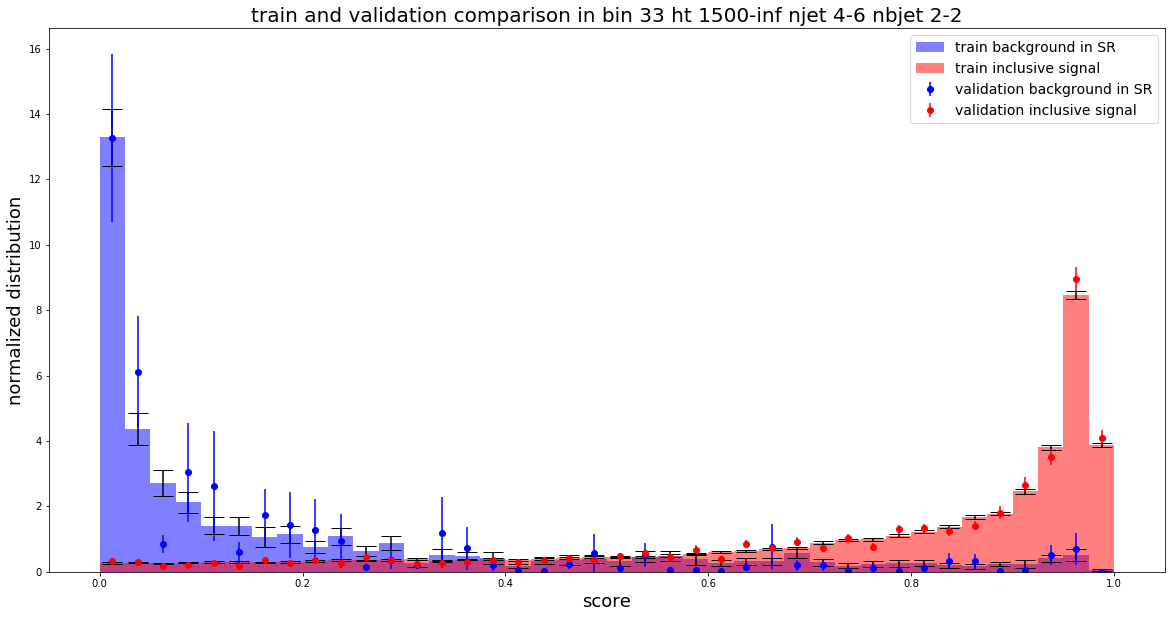

In [94]:
figcompare = plot_train_val_compare(train0,train1,val0,val1,'train and validation comparison in bin '+str(i)+' ht '+str(binning.selections[i][0][0])
                       +"-"+str(binning.selections[i][0][1])+" njet "+str(binning.selections[i][1][0])+"-"+str(binning.selections[i][1][1]-1)
                       +" nbjet "+str(binning.selections[i][2][0])+"-"+str(binning.selections[i][2][1]-1))

In [95]:
figcompare.savefig("train_val_compare_bin"+str(i)+".png")
figcompare.savefig("train_val_compare_bin"+str(i)+".pdf")

In [170]:
def plot_sig_bkg_compare(sig,bkg,mass1,mass2,title):
    bins=np.arange(0,1.025,0.025)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    bkg_top=bkg[(bkg[b'bkgtype']==0)|(bkg[b'bkgtype']==1)]
    bkg_wjets=bkg[bkg[b'bkgtype']==2]
    bkg_zinv=bkg[bkg[b'bkgtype']==3]

    sig_exclu=sig[(sig[b'GenSusyMScan1']==mass1)&(sig[b'GenSusyMScan2']==mass2)]

    err2_bkg,binEdges=np.histogram(bkg[b'MLscore'],bins=bins,weights=bkg[b'w2'])
    err2_sig_exclu,_=np.histogram(sig_exclu[b'MLscore'],bins=bins,weights=sig_exclu[b'w2'])
    err2_sig,_=np.histogram(sig[b'MLscore'],bins=bins,weights=sig[b'w2'])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    width      = binEdges[1]-binEdges[0]

    hist_bkg_top,_=np.histogram(bkg_top[b'MLscore'],bins=bins,weights=bkg_top[b'absweight'])
    hist_bkg_wjets,_=np.histogram(bkg_wjets[b'MLscore'],bins=bins,weights=bkg_wjets[b'absweight'])
    hist_bkg_zinv,_=np.histogram(bkg_zinv[b'MLscore'],bins=bins,weights=bkg_zinv[b'absweight'])
    sum_bkg=np.sum(hist_bkg_top)+np.sum(hist_bkg_wjets)+np.sum(hist_bkg_zinv)
    hist_bkg_top=np.divide(hist_bkg_top,sum_bkg*width)
    hist_bkg_wjets=np.divide(hist_bkg_wjets,sum_bkg*width)
    hist_bkg_zinv=np.divide(hist_bkg_zinv,sum_bkg*width)
    err_bkg=np.divide(np.sqrt(err2_bkg),sum_bkg*width)

    hist_sig_exclu,_=np.histogram(sig_exclu[b'MLscore'],bins=bins,weights=sig_exclu[b'absweight'])
    sum_sig_exclu=np.sum(hist_sig_exclu)
    hist_sig_exclu=np.divide(hist_sig_exclu,sum_sig_exclu*width)
    err_sig_exclu=np.divide(np.sqrt(err2_sig_exclu),sum_sig_exclu*width)
    hist_sig,_=np.histogram(sig[b'MLscore'],bins=bins,weights=sig[b'absweight'])
    sum_sig=np.sum(hist_sig)
    hist_sig=np.divide(hist_sig,sum_sig*width)
    err_sig=np.divide(np.sqrt(err2_sig),sum_sig*width)

    ax.bar(bincenters,hist_bkg_top,width=width,color='lightskyblue',alpha=0.7,label="top background in SR")
    ax.bar(bincenters,hist_bkg_wjets,bottom=hist_bkg_top,width=width,color='tan',alpha=0.7,label="wjets background in SR")
    ax.bar(bincenters,hist_bkg_zinv,bottom=hist_bkg_top+hist_bkg_wjets,width=width,color='thistle',yerr=err_bkg,alpha=0.7,label="zinv background in SR",capsize=5)

    ax.bar(bincenters,hist_sig,width=width,linewidth=0,capsize=5,ecolor='blue',yerr=err_sig,fill=False)
    ax.bar(bincenters,hist_sig_exclu,width=width,linewidth=0,capsize=5,ecolor='red',yerr=err_sig_exclu,fill=False)

    ax.step(bincenters[0:(len(bincenters))],hist_sig,where='mid',linewidth=2,linestyle='dashed',color='blue',label='inclusive signal')
    ax.step(bincenters[0:(len(bincenters))],hist_sig_exclu,where='mid',linewidth=2,linestyle='solid',color='red',label='signal gluino '+str(mass1)+'GeV \n neutralino '+str(mass2)+'GeV')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(loc='best',prop={'size': 16})
    ax.set_xlabel('score',fontsize=20)
    ax.set_ylabel("normalized distribution",fontsize=20)
    ax.set_title(title,size=22)
    return fig

In [164]:
bincenters

NameError: name 'bincenters' is not defined

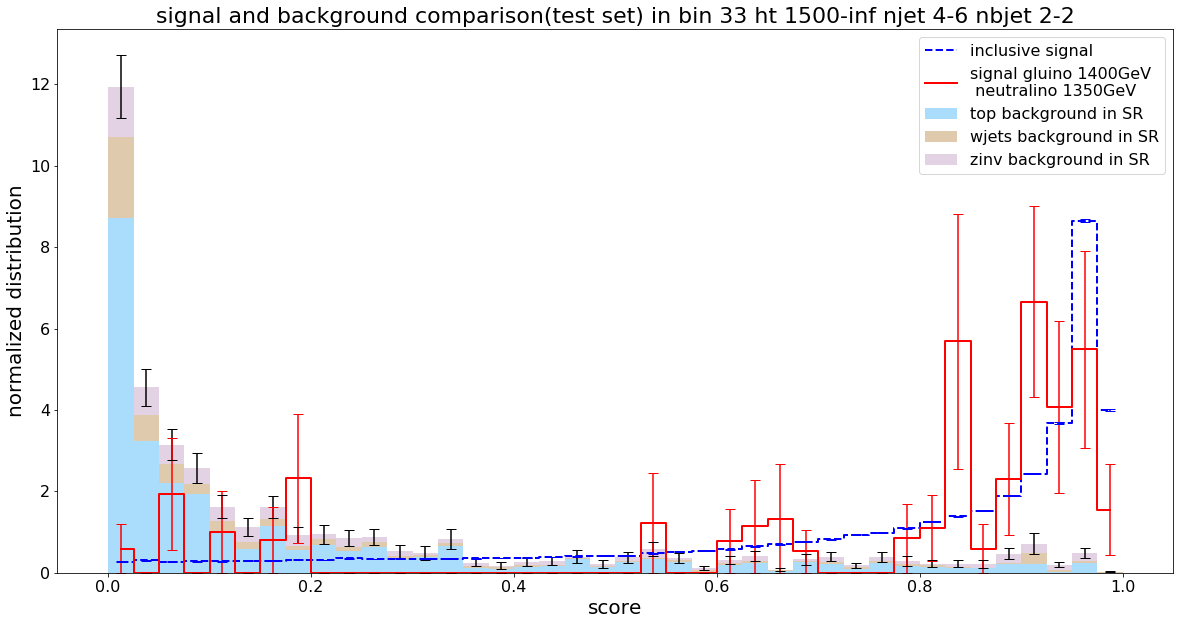

In [171]:
figtest = plot_sig_bkg_compare(datasig_test_bin[i],databkg_test_bin[i],m1,m2,'signal and background comparison(test set) in bin '
                       +str(i)+' ht '+str(binning.selections[i][0][0])
                       +"-"+str(binning.selections[i][0][1])+" njet "+str(binning.selections[i][1][0])+"-"+str(binning.selections[i][1][1]-1)
                       +" nbjet "+str(binning.selections[i][2][0])+"-"+str(binning.selections[i][2][1]-1))

In [120]:
figtest.savefig("sig_bkg_compare_bin"+str(i)+".png")
figtest.savefig("sig_bkg_compare_bin"+str(i)+".pdf")

In [124]:
def plot_CR_llep(MC,data,title):
    bins=np.arange(0,1.025,0.025)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    MC_top=MC[(MC[b'bkgtype']==0)|(MC[b'bkgtype']==1)]
    MC_wjets=MC[MC[b'bkgtype']==2]

    err2_MC,binEdges=np.histogram(MC[b'MLscore'],bins=bins,weights=MC[b'w2'])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    width      = binEdges[1]-binEdges[0]

    hist_MC_top,_=np.histogram(MC_top[b'MLscore'],bins=bins,weights=MC_top[b'absweight'])
    hist_MC_wjets,_=np.histogram(MC_wjets[b'MLscore'],bins=bins,weights=MC_wjets[b'absweight'])

    sum_MC=np.sum(hist_MC_top)+np.sum(hist_MC_wjets)
    hist_MC_top=np.divide(hist_MC_top,sum_MC*width)
    hist_MC_wjets=np.divide(hist_MC_wjets,sum_MC*width)
    err_MC=np.divide(np.sqrt(err2_MC),sum_MC*width)

    hist_data,_=np.histogram(data[b'MLscore'],bins=bins)
    sum_data=np.sum(hist_data)
    err_data=np.divide(np.sqrt(hist_data),sum_data*width)
    hist_data=np.divide(hist_data,sum_data*width)

    ax.bar(bincenters,hist_MC_top,width=width,color='lightskyblue',alpha=0.7,label="top(MC) in llep CR")
    ax.bar(bincenters,hist_MC_wjets,bottom=hist_MC_top,width=width,color='tan',yerr=err_MC,alpha=0.7,label="wjets(MC) in llep CR",capsize=10)

    ax.errorbar(bincenters,hist_data,yerr=err_data,xerr=None,ecolor='red',c='red',fmt='o',label='data in llep CR')

    ax.legend(loc='best',prop={'size': 14})
    ax.set_xlabel('score',fontsize=18)
    ax.set_ylabel("normalized distribution",fontsize=18)
    ax.set_title(title,size=20)
    return fig

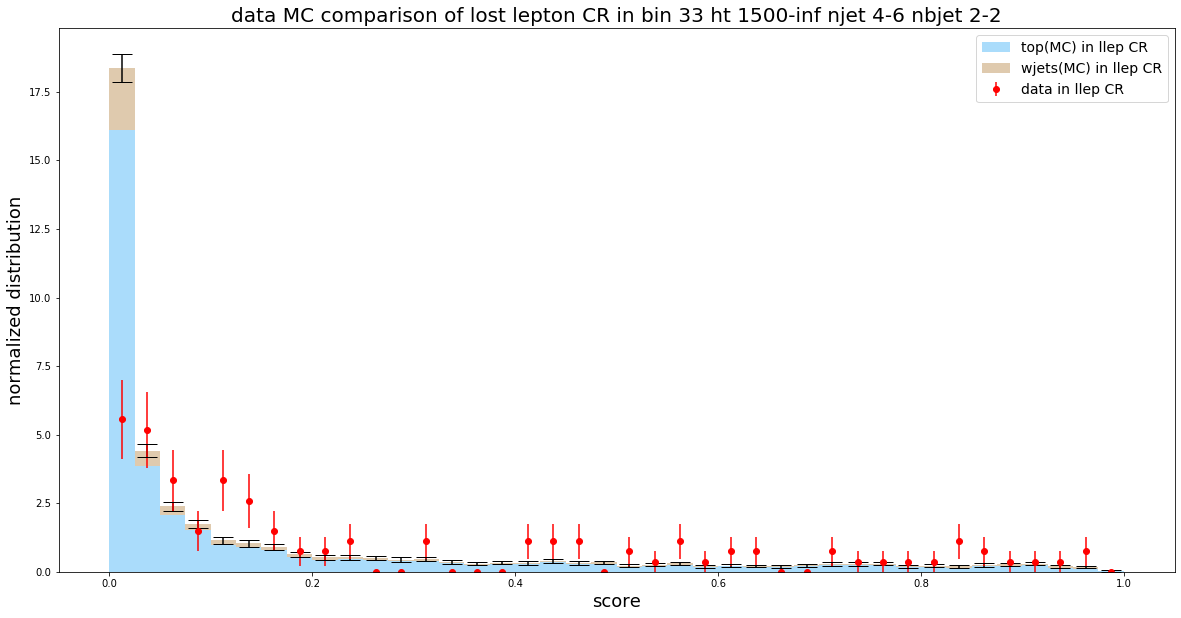

In [125]:
figllep=plot_CR_llep(llepMC[i],llepdata[i],'data MC comparison of lost lepton CR in bin '+str(i)+' ht '+str(binning.selections[i][0][0])
                       +"-"+str(binning.selections[i][0][1])+" njet "+str(binning.selections[i][1][0])+"-"+str(binning.selections[i][1][1]-1)
                       +" nbjet "+str(binning.selections[i][2][0])+"-"+str(binning.selections[i][2][1]-1))
figllep.savefig("llepCR_bin"+str(i)+".png")
figllep.savefig("llepCR_bin"+str(i)+".pdf")

In [143]:
def plot_CR_zll(MC,data,title):
    bins=np.arange(0,1.025,0.025)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    err2_MC,binEdges=np.histogram(MC[b'MLscore'],bins=bins,weights=MC[b'w2'])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    width      = binEdges[1]-binEdges[0]

    hist_MC,_=np.histogram(MC[b'MLscore'],bins=bins,weights=MC[b'absweight'])
    sum_MC=np.sum(hist_MC)
    print(sum_MC)
    hist_MC=np.divide(hist_MC,sum_MC*width)
    err_MC=np.divide(np.sqrt(err2_MC),sum_MC*width)

    hist_data,_=np.histogram(data[b'MLscore'],bins=bins)
    sum_data=np.sum(hist_data)
    print(sum_data)
    err_data=np.divide(np.sqrt(hist_data),sum_data*width)
    hist_data=np.divide(hist_data,sum_data*width)

    ax.bar(bincenters,hist_MC,width=width,color='thistle',yerr=err_MC,alpha=0.7,label="dyjetsll(MC) in zll CR",capsize=10)
    ax.errorbar(bincenters,hist_data,yerr=err_data,xerr=None,ecolor='red',c='red',fmt='o',label='data in zll CR')

    ax.legend(loc='best',prop={'size': 14})
    ax.set_xlabel('score',fontsize=18)
    ax.set_ylabel("normalized distribution",fontsize=18)
    ax.set_title(title,size=20)
    return fig

0.8849931891116649
102


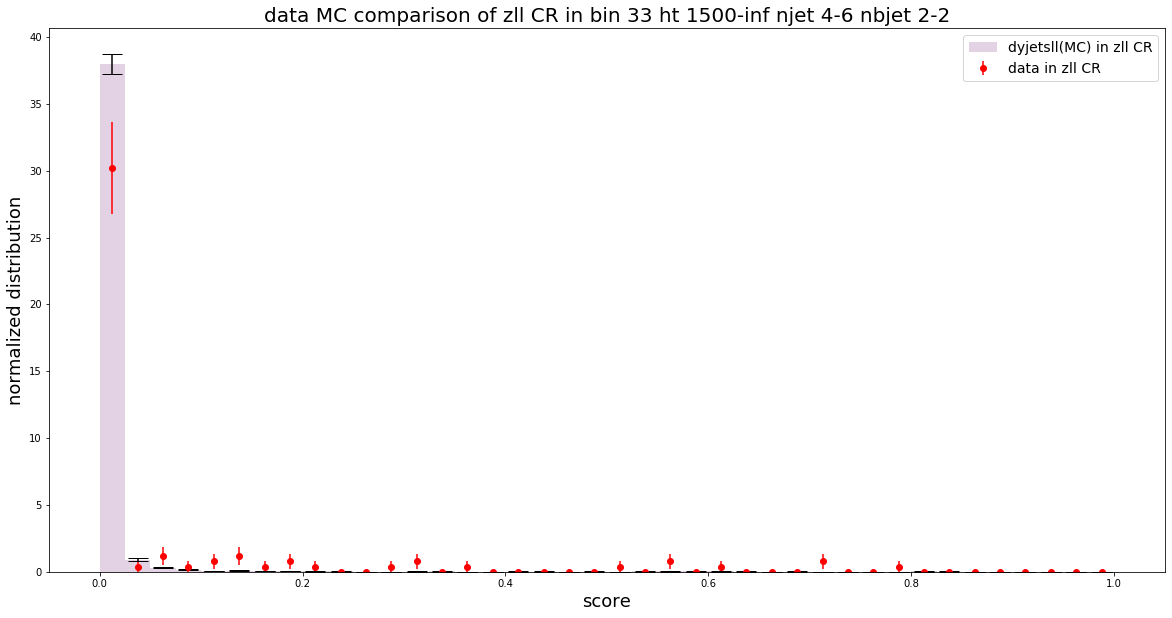

In [145]:
figzll=plot_CR_zll(zllMC[i],zlldata[i],'data MC comparison of zll CR in bin '+str(i)+' ht '+str(binning.selections[i][0][0])
                       +"-"+str(binning.selections[i][0][1])+" njet "+str(binning.selections[i][1][0])+"-"+str(binning.selections[i][1][1]-1)
                       +" nbjet "+str(binning.selections[i][2][0])+"-"+str(binning.selections[i][2][1]-1))
figzll.savefig("zllCR_bin"+str(i)+".png")
figzll.savefig("zllCR_bin"+str(i)+".pdf")

In [146]:
figzll.savefig("zllCR_bin"+str(i)+".png")
figzll.savefig("zllCR_bin"+str(i)+".pdf")

In [147]:
midsig=methods.computesignificance(databkg_test_bin[i],datasig_test_bin[i],zllMC[i],llepMC[i],
                                           zlldata[i],llepdata[i],m1,m2,1-MLuse_bkg[i],1-MLuse_sig[i],0.005)

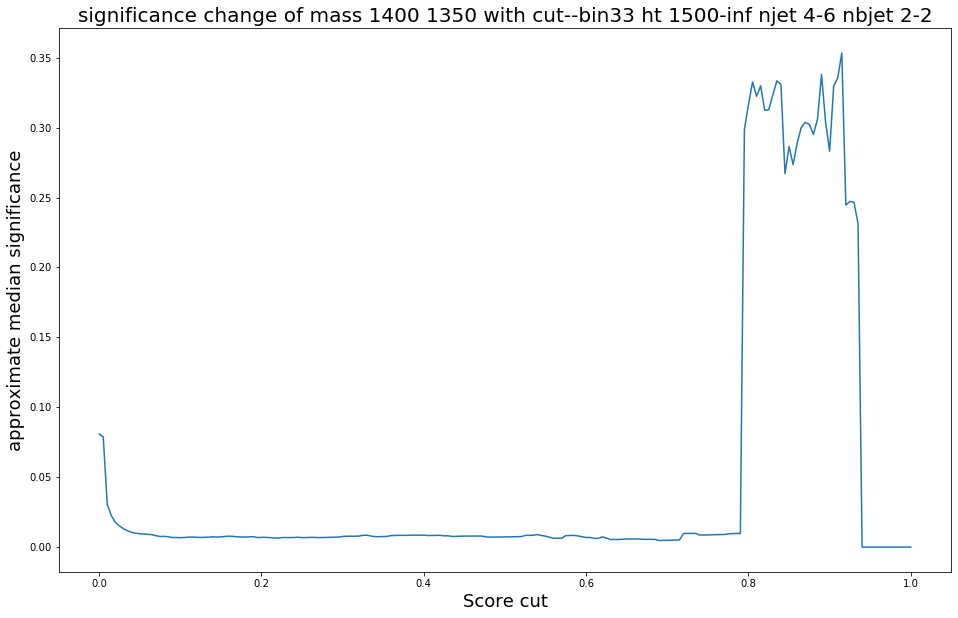

In [148]:
figmidsig=methods.plot_significance(midsig,'significance change of mass '+str(m1)+" "+str(m2) +" with cut--bin"
                       +str(i)+' ht '+str(binning.selections[i][0][0])
                       +"-"+str(binning.selections[i][0][1])+" njet "+str(binning.selections[i][1][0])+"-"+str(binning.selections[i][1][1]-1)
                       +" nbjet "+str(binning.selections[i][2][0])+"-"+str(binning.selections[i][2][1]-1))

In [149]:
models_forbin['significance'][j].append(midsig)

In [151]:
figmidsig.savefig("significance_bin_"+str(i)+"_mass_"+str(m1)+"_"+str(m2)+".png")
figmidsig.savefig("significance_bin_"+str(i)+"_mass_"+str(m1)+"_"+str(m2)+".pdf")

In [152]:
midsig

[0.08089673420206912,
 0.07890239303197817,
 0.03037149441777276,
 0.022477282706610962,
 0.01762582456197963,
 0.015165919519608877,
 0.013105040366596703,
 0.011646940055938934,
 0.010571029683411087,
 0.009938105378121528,
 0.009529521644839391,
 0.009395265945587044,
 0.009093748870131096,
 0.008929087830918087,
 0.008123183031414826,
 0.007577165960227088,
 0.007687315186509639,
 0.007407678025514853,
 0.00686527976195464,
 0.006855492780954739,
 0.006727283265960989,
 0.006850092779038769,
 0.007110592189320139,
 0.007137655879648896,
 0.007020089658248827,
 0.006880190138123513,
 0.006971522969362582,
 0.007132901819742716,
 0.007371419634224629,
 0.0071443839678746535,
 0.00731574197821585,
 0.007615786007888044,
 0.0077758255078952294,
 0.0076561825272299265,
 0.007334488467150606,
 0.007258443945148793,
 0.007183576465542415,
 0.0073407071804639035,
 0.0074642362471792,
 0.006839959453721997,
 0.006962938354758544,
 0.006989093566305236,
 0.006756845818089904,
 0.006566996062

In [153]:
models_forbin

{'mass': [[1400, 1350], [2400, 200]],
 'binindex': [[33, 19], [33, 34]],
 'significance': [[[0.08089673420206912,
    0.07890239303197817,
    0.03037149441777276,
    0.022477282706610962,
    0.01762582456197963,
    0.015165919519608877,
    0.013105040366596703,
    0.011646940055938934,
    0.010571029683411087,
    0.009938105378121528,
    0.009529521644839391,
    0.009395265945587044,
    0.009093748870131096,
    0.008929087830918087,
    0.008123183031414826,
    0.007577165960227088,
    0.007687315186509639,
    0.007407678025514853,
    0.00686527976195464,
    0.006855492780954739,
    0.006727283265960989,
    0.006850092779038769,
    0.007110592189320139,
    0.007137655879648896,
    0.007020089658248827,
    0.006880190138123513,
    0.006971522969362582,
    0.007132901819742716,
    0.007371419634224629,
    0.0071443839678746535,
    0.00731574197821585,
    0.007615786007888044,
    0.0077758255078952294,
    0.0076561825272299265,
    0.007334488467150606,
    